# Sentiment Analysis

In [24]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline

In [25]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
#!pip install -U textblob
#python -m textblob.download_corpora

In [26]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv", index_col=0)
print(df.shape)
df.head(3)

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [27]:
df.groupby(['Rating', 'Recommended IND'])['Recommended IND'].count()

Rating  Recommended IND
1       0                    826
        1                     16
2       0                   1471
        1                     94
3       0                   1682
        1                   1189
4       0                    168
        1                   4909
5       0                     25
        1                  13106
Name: Recommended IND, dtype: int64

In [28]:
df.loc[(df.Rating==5) & (df['Recommended IND']==0)]['Review Text'].iloc[1]

"This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin."

In [29]:
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


In [30]:
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [31]:
text_df.Review.isna().sum()

3811

In [32]:
text_df = text_df[~text_df.Review.isna()]
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (19675, 2)


,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


In [33]:
text_df['Recommended'].unique()
text_df['Recommended'].value_counts(normalize=True)

array([0, 1], dtype=int64)

1    0.818297
0    0.181703
Name: Recommended, dtype: float64

In [34]:
text_df['Review_length'] = text_df['Review'].apply(len)
print(text_df.shape)
text_df.head()

(19675, 3)


,Recommended,Review,Review_length
2,0,Some major design flaws I had such high hopes ...,524
3,1,"My favorite buy! I love, love, love this jumps...",141
4,1,Flattering shirt This shirt is very flattering...,209
5,0,Not for the very petite I love tracy reese dre...,512
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517


count    19675.000000
mean       338.450267
std        144.740126
min         23.000000
25%        217.000000
50%        336.000000
75%        496.000000
max        557.000000
Name: Review_length, dtype: float64

<AxesSubplot:xlabel='Review_length', ylabel='Density'>

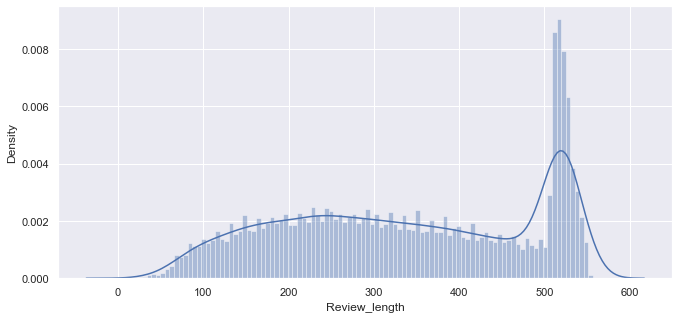

In [35]:
text_df['Review_length'].describe()
sns.set(rc={'figure.figsize':(11,5)})
sns.distplot(text_df['Review_length'] ,hist=True, bins=100)

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

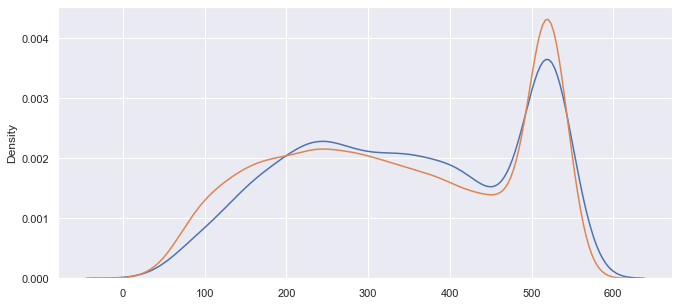

In [36]:
df_zero = text_df[text_df['Recommended']==0]
df_one = text_df[text_df['Recommended']==1]
sns.distplot(df_zero[['Review_length']] ,hist=False)
sns.distplot(df_one[['Review_length']], hist=False)

In [37]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

text_df['count_exc'] = text_df['Review'].apply(count_exclamation_mark)
text_df.head(5)

,Recommended,Review,Review_length,count_exc
2,0,Some major design flaws I had such high hopes ...,524,1
3,1,"My favorite buy! I love, love, love this jumps...",141,3
4,1,Flattering shirt This shirt is very flattering...,209,3
5,0,Not for the very petite I love tracy reese dre...,512,0
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0


count    19675.000000
mean         0.883151
std          1.412098
min          0.000000
20%          0.000000
40%          0.000000
50%          0.000000
60%          1.000000
80%          2.000000
max         41.000000
Name: count_exc, dtype: float64

<AxesSubplot:>

Int64Index([3301], dtype='int64')

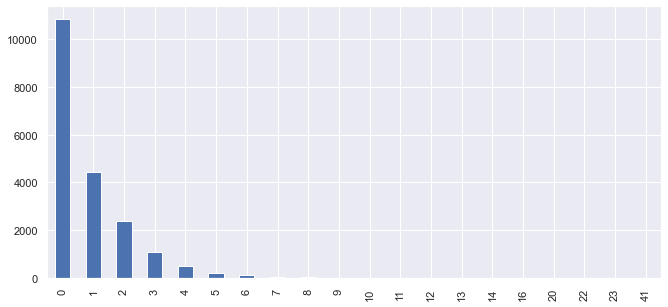

In [38]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')
text_df[text_df['count_exc']== 41].index

'Beautiful and unique. Love this top, just received it today.\r\nit is a very artistic interpretation for a casual top.\r\nthe blue is gorgeous!\r\nthe unique style of the peplm and the details on the front set this apart!\r\nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.\r\nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\r\nordered my usual size and it fits perfectly.'

,Recommended,Review,Review_length,count_exc,Polarity
2,0,Some major design flaws I had such high hopes ...,524,1,0.073209
3,1,"My favorite buy! I love, love, love this jumps...",141,3,0.560714
4,1,Flattering shirt This shirt is very flattering...,209,3,0.512891
5,0,Not for the very petite I love tracy reese dre...,512,0,0.181111
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0,0.157500


<AxesSubplot:ylabel='Frequency'>

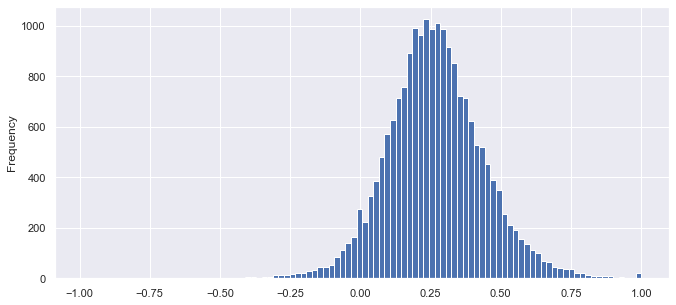

In [39]:
text_df['Review'][3301]
text_df['Polarity'] = text_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)
text_df['Polarity'].plot(kind='hist', bins=100)

In [40]:
text_prep = text_df.copy()

In [41]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [42]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

text_prep['Review'] = text_prep['Review'].apply(punctuation_removal)
text_prep['Review'].head()

2    Some major design flaws I had such high hopes ...
3    My favorite buy I love love love this jumpsuit...
4    Flattering shirt This shirt is very flattering...
5    Not for the very petite I love tracy reese dre...
6    Cagrcoal shimmer fun I aded this in my basket ...
Name: Review, dtype: object

In [43]:
Image(url= "http://josecarilloforum.com/imgs/longnounphrase_schematic-1B.png", width=600, height=10)

In [44]:
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #Verbs and Adjectives
            new_string.append(tup[0])  
    return ' '.join(new_string)

text_prep['Review'] = text_prep['Review'].apply(adj_collector)
text_prep['Review'].head(7)

2    major had such high wanted work i ordered smal...
3         favorite love love fabulous wear i get great
4    Flattering is flattering due adjustable is per...
5    petite love reese is petite am tall wear was i...
6    aded last see look i went am pale is gorgeous ...
7    goes ordered had try used top pair went is nic...
8    Flattering love get runs little ordered flatte...
Name: Review, dtype: object

In [45]:
print(stopwords.words('english')[::12])
stop = stopwords.words('english')
stop.append("i'm")

stop_words = []
for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 
print(stop_words[::12])

['i', "you'd", 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', "don't", 'aren', 'haven', "shan't"]
['i', 'youd', 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', 'dont', 'aren', 'haven', 'shant']


In [46]:
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

In [47]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

In [48]:
text_prep['Review'] = text_prep['Review'].apply(stopwords_removal)
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [49]:
print(text_prep['Review'][3301])
print(text_prep['Review'][267]) 

['unique', 'received', 'artistic', 'casual', 'gorgeous', 'unique', 'runs', 'little', 'feel', 'enhances', 'appropriate', 'overall', 'ordered', 'usual', 'fits']
['nice', 'short', 'tall', 'iamp39d', 'say', 'fits', 'true', 'short', 'iamp39m', 'tall', 'wish', 'came']


In [50]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
text_prep['Review'] = text_prep['Review'].apply(drop_numbers)
text_prep['Review'].head()

2    major high wanted work ordered small usual fou...
3                favorite love love fabulous get great
4    flattering flattering due adjustable perfect p...
5    petite love reese petite tall long full overwh...
6    aded last see look went pale gorgeous turns ma...
Name: Review, dtype: object

In [51]:
print(text_prep['Review'][267]) 
print(text_prep['Review'][2293])

nice short tall say fits true short tall wish came
flattering purchased return expected fit said lbs got get disappointed soft purchase regular fit looked terrible say tall thin yes short petite


## stemming

In [52]:
porter = PorterStemmer()

In [53]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: x.split())
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [54]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new
text_prep['Review'] = text_prep['Review'].apply(stem_update)
text_prep['Review'].head()
text_prep['Review'] = text_prep['Review'].apply(lambda x: ' '.join(x))
text_prep['Review'].head()

2    [major, high, want, work, order, small, usual,...
3             [favorit, love, love, fabul, get, great]
4    [flatter, flatter, due, adjust, perfect, pair,...
5    [petit, love, rees, petit, tall, long, full, o...
6    [ade, last, see, look, went, pale, gorgeou, tu...
Name: Review, dtype: object

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

## wordcloud

In [55]:
pos_df = text_prep[text_prep.Recommended== 1]
neg_df = text_prep[text_prep.Recommended== 0]
pos_df.head(3)

,Recommended,Review,Review_length,count_exc,Polarity
3,1,favorit love love fabul get great,141,3,0.560714
4,1,flatter flatter due adjust perfect pair cardigan,209,3,0.512891
6,1,ade last see look went pale gorgeou turn mathc...,517,0,0.157500


In [56]:
pos_words =[]
neg_words = []

for review in pos_df.Review:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for review in neg_df.Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'favorit love love fabul get great flatte'

'major high want work order small usual found small small zip reorder petit ok overal comfort fit bottom tight sever cheap imo major net c petit love rees petit tall long full overwhelm small shorten narrow take love work return look cheap run small run order fit tight cheap pull caus rip disappoint go say go look style side purchas knew larg next imposs second look cheap awkward tight look describ'

<Figure size 936x936 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

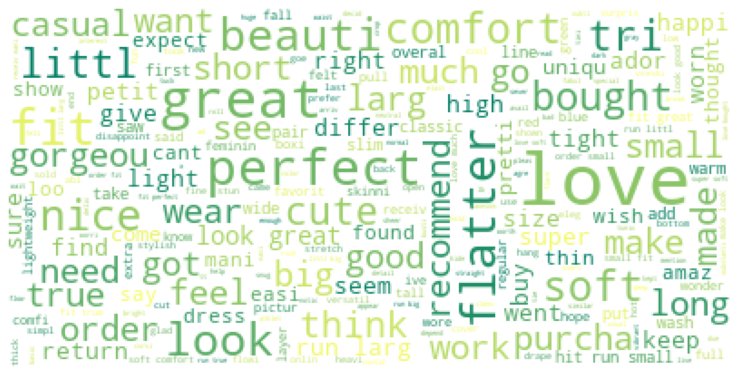

In [57]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<Figure size 936x936 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

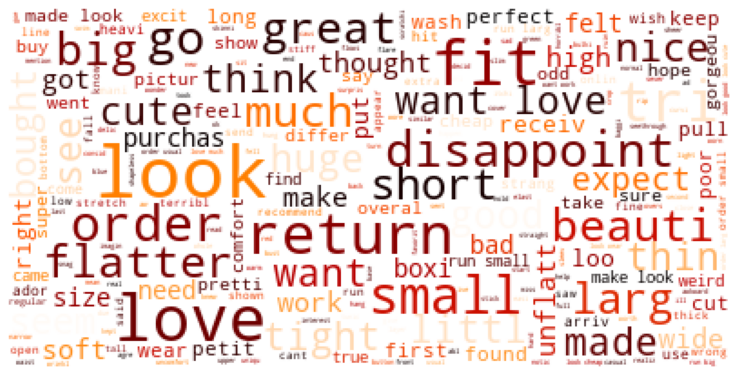

In [58]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Vectorizing - Bag of Words

In [59]:
def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

In [66]:
bow_transformer = CountVectorizer(text_vectorizing_process) #??????????

TypeError: __init__() takes 1 positional argument but 2 were given

In [67]:
bow_transformer.fit(text_prep['Review'])
print(text_prep['Review'].iloc[3])

CountVectorizer()

petit love rees petit tall long full overwhelm small shorten narrow take love work return


In [68]:
example = bow_transformer.transform([text_prep['Review'].iloc[3]])
print(example)

  (0, 2416)	1
  (0, 3438)	1
  (0, 3507)	2
  (0, 3881)	1
  (0, 4302)	1
  (0, 4438)	2
  (0, 4875)	1
  (0, 5004)	1
  (0, 5383)	1
  (0, 5601)	1
  (0, 6196)	1
  (0, 6201)	1
  (0, 7159)	1


In [69]:
Reviews = bow_transformer.transform(text_prep['Review'])
Reviews
print('Shape of Sparse Matrix', Reviews.shape)
print('Amount of Non-Zero occurences:', Reviews.nnz)

<19675x7277 sparse matrix of type '<class 'numpy.int64'>'
	with 237960 stored elements in Compressed Sparse Row format>

Shape of Sparse Matrix (19675, 7277)
Amount of Non-Zero occurences: 237960


## TF-IDF

In [70]:
tfidf_transformer = TfidfTransformer().fit(Reviews)

tfidf_example = tfidf_transformer.transform(example)
print (tfidf_example)

  (0, 7159)	0.18474832182622425
  (0, 6201)	0.2570248132639302
  (0, 6196)	0.2365171129379326
  (0, 5601)	0.1442941606293562
  (0, 5383)	0.355252429679757
  (0, 5004)	0.1888712992199643
  (0, 4875)	0.393148931086517
  (0, 4438)	0.4065409531496632
  (0, 4302)	0.3214748504588952
  (0, 3881)	0.3072123012448639
  (0, 3507)	0.21175884431125436
  (0, 3438)	0.20250236542769373
  (0, 2416)	0.2403172376641177


In [71]:
[i for i in bow_transformer.vocabulary_.items() if i[1]==3507]
[i for i in bow_transformer.vocabulary_.items()][6:60:10]

[('love', 3507)]

[('usual', 6813),
 ('tight', 6383),
 ('flatter', 2243),
 ('overwhelm', 4302),
 ('pale', 4323),
 ('said', 5133)]

In [72]:
messages_tfidf = tfidf_transformer.transform(Reviews)
messages_tfidf.shape
print(messages_tfidf[:1]) 

(19675, 7277)

  (0, 7273)	0.21472646647428087
  (0, 7159)	0.12712196996857394
  (0, 6930)	0.12017260570324308
  (0, 6813)	0.1513403250714934
  (0, 6383)	0.14060642619885752
  (0, 5601)	0.29785858576976637
  (0, 5290)	0.18845614450376966
  (0, 4943)	0.2444427546112772
  (0, 4438)	0.13986672876492434
  (0, 4260)	0.15858178150697497
  (0, 4210)	0.1001757163619286
  (0, 4138)	0.20901503445074096
  (0, 3944)	0.30397328049150685
  (0, 3584)	0.5250571838807988
  (0, 2934)	0.3111586573431781
  (0, 2769)	0.14606384138147635
  (0, 2364)	0.15056928107008546
  (0, 2197)	0.08515558755200825
  (0, 1153)	0.10625437706817653
  (0, 984)	0.19198542692781725
  (0, 698)	0.18408106529286453


In [73]:
messages_tfidf = messages_tfidf.toarray()
messages_tfidf = pd.DataFrame(messages_tfidf)
print(messages_tfidf.shape)
messages_tfidf.head()

(19675, 7277)


,0,1,2,3,4,5,6,7,8,9,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214726,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [74]:
df_all = pd.merge(text_prep.drop(columns='Review'),messages_tfidf, 
                  left_index=True, right_index=True )
df_all.head()

,Recommended,Review_length,count_exc,Polarity,0,1,2,3,4,5,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
2,0,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# Splitting the data

In [76]:
X = df_all.drop('Recommended', axis=1)
y = df_all.Recommended

X.head()
X.shape
X.describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
2,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(16481, 7280)

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
count,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.0,16481.000000,16481.000000,16481.000000,...,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000
mean,338.411261,0.876221,0.265987,0.000024,0.000030,0.000024,0.0,0.000049,0.000021,0.000020,...,0.000023,0.000025,0.000076,0.000048,0.000054,0.000021,0.002118,0.000315,0.000030,0.000125
std,144.790275,1.414203,0.172803,0.003139,0.003794,0.003098,0.0,0.004483,0.002695,0.002549,...,0.002950,0.003207,0.004952,0.004398,0.004935,0.002727,0.027395,0.010892,0.003799,0.007291
min,23.000000,0.000000,-0.987500,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,217.000000,0.000000,0.158333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,335.000000,0.000000,0.260863,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,497.000000,1.000000,0.370312,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,557.000000,41.000000,1.000000,0.402938,0.487124,0.397730,0.0,0.447529,0.345954,0.327234,...,0.378710,0.411733,0.382191,0.400114,0.496872,0.350060,0.629020,0.484828,0.487690,0.526867


In [77]:
X_train, X_test, y_train, y_test = split(X,y, test_size=0.3, stratify=y, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11536, 7280), (4945, 7280), (11536,), (4945,))

In [78]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

1    0.818741
0    0.181259
Name: Recommended, dtype: float64

1    0.818605
0    0.181395
Name: Recommended, dtype: float64

In [79]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
# Data Visualization (PCA)
pca_transformer = PCA(n_components=2).fit(X_train_scaled)
X_train_scaled_pca = pca_transformer.transform(X_train_scaled)
X_test_scaled_pca = pca_transformer.transform(X_test_scaled)
X_train_scaled_pca[:1]

array([[-0.13600042, -0.05005755]])

<Figure size 1080x504 with 0 Axes>

<AxesSubplot:>

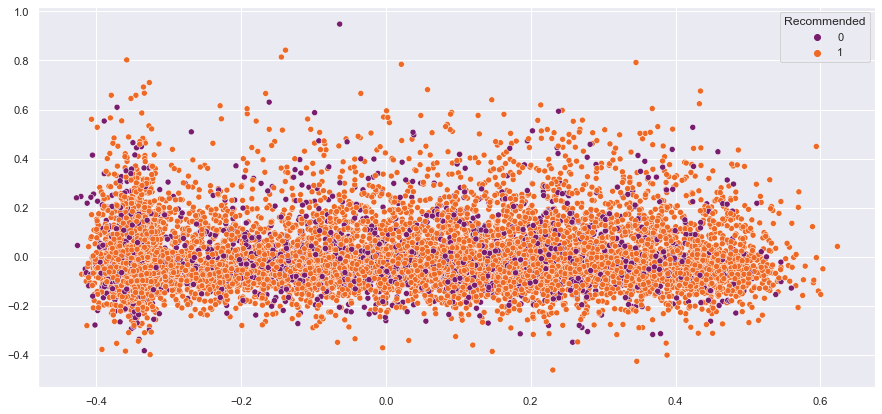

In [81]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_train_scaled_pca[:, 0], 
                y=X_train_scaled_pca[:, 1], 
                hue=y_train, 
                sizes=100,
                palette="inferno") 

In [82]:
X_train_scaled = scipy.sparse.csr_matrix(X_train_scaled)
X_test_scaled = scipy.sparse.csr_matrix(X_test_scaled)

X_train = scipy.sparse.csr_matrix(X_train.values)
X_test = scipy.sparse.csr_matrix(X_test.values)
X_test

<4945x7280 sparse matrix of type '<class 'numpy.float64'>'
	with 71934 stored elements in Compressed Sparse Row format>

## Models

In [83]:
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

In [84]:
svc_model = SVC(C=1.0, 
             kernel='linear',
             class_weight='balanced', 
             probability=True,
             random_state=111)
svc_model.fit(X_train_scaled, y_train)
test_predictions = svc_model.predict(X_test_scaled)
print(report(y_test, test_predictions, svc_model.classes_ ))

SVC(class_weight='balanced', kernel='linear', probability=True,
    random_state=111)

Confusion Matrix:
     0     1
0  517   380
1  995  3053

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.58      0.43       897
           1       0.89      0.75      0.82      4048

    accuracy                           0.72      4945
   macro avg       0.62      0.67      0.62      4945
weighted avg       0.79      0.72      0.75      4945



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

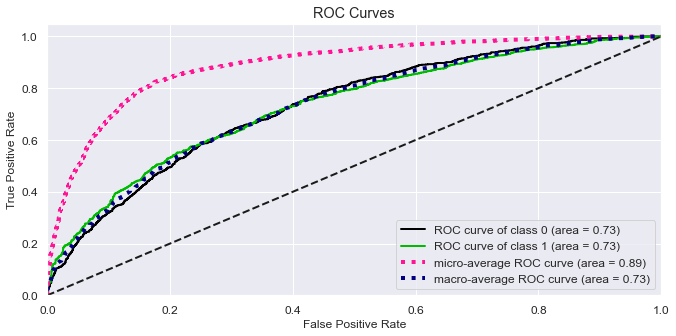

In [85]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test_scaled))

In [86]:
lr_model = LogisticRegression(class_weight='balanced', 
                              random_state=111, 
                              solver='lbfgs',
                              C=1.0)

gs_lr_model = GridSearchCV(lr_model, 
                           param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, 
                           cv=5, 
                           scoring='roc_auc')

gs_lr_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=111),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, scoring='roc_auc')

In [87]:
gs_lr_model.best_params_
test_predictions = gs_lr_model.predict(X_test_scaled)
print(report(y_test, test_predictions, gs_lr_model.classes_ ))

{'C': 0.1}

Confusion Matrix:
      0     1
0   617   280
1  1100  2948

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.69      0.47       897
           1       0.91      0.73      0.81      4048

    accuracy                           0.72      4945
   macro avg       0.64      0.71      0.64      4945
weighted avg       0.81      0.72      0.75      4945



<AxesSubplot:title={'center':'ROC Curves - Logistic Regression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

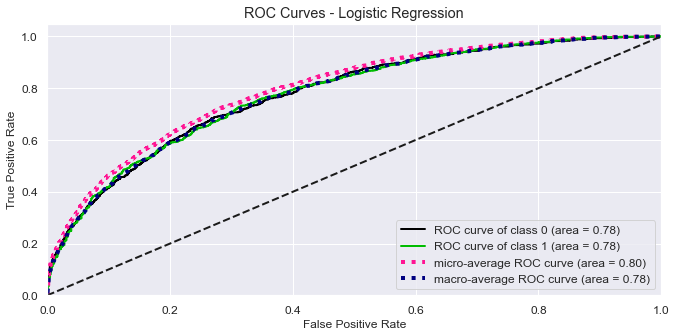

In [88]:
skplt.metrics.plot_roc(y_test, gs_lr_model.predict_proba(X_test_scaled),
                      title='ROC Curves - Logistic Regression') 

In [89]:
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=555)

ada_model = AdaBoostClassifier(base_estimator=dt, learning_rate=0.001, n_estimators=1000, random_state=222)
ada_model.fit(X_train ,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=5,
                                                         random_state=555),
                   learning_rate=0.001, n_estimators=1000, random_state=222)

Confusion Matrix:
     0     1
0  549   348
1  916  3132

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.61      0.46       897
           1       0.90      0.77      0.83      4048

    accuracy                           0.74      4945
   macro avg       0.64      0.69      0.65      4945
weighted avg       0.80      0.74      0.77      4945



<AxesSubplot:title={'center':'ROC Curves - AdaBoost'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

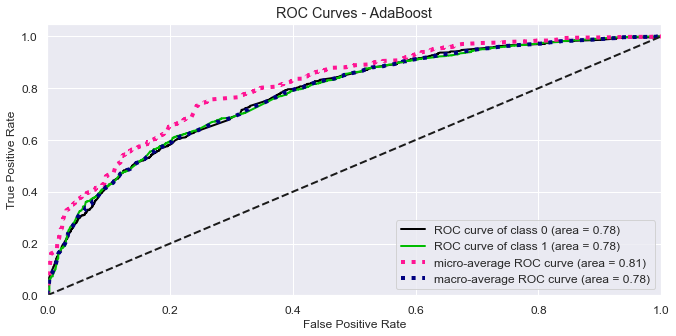

In [90]:
test_predictions = ada_model.predict(X_test)
print(report(y_test, test_predictions, ada_model.classes_ ))
skplt.metrics.plot_roc(y_test, ada_model.predict_proba(X_test), 
                       title='ROC Curves - AdaBoost') 

In [91]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5, 
                                  class_weight='balanced', random_state=3)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=1000,
                       random_state=3)

Confusion Matrix:
     0     1
0  535   362
1  828  3220

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.60      0.47       897
           1       0.90      0.80      0.84      4048

    accuracy                           0.76      4945
   macro avg       0.65      0.70      0.66      4945
weighted avg       0.81      0.76      0.78      4945



<AxesSubplot:title={'center':'ROC Curves - Random Forest'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

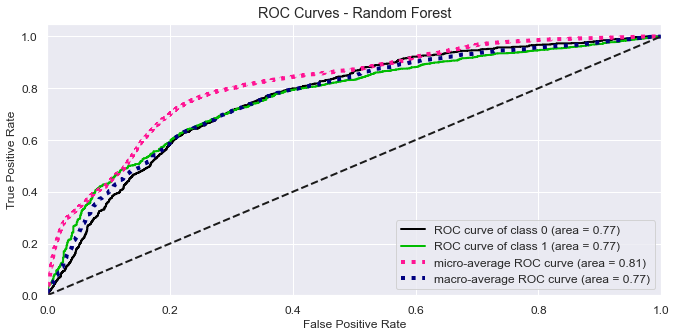

In [92]:
test_predictions = rf_model.predict(X_test)
print(report(y_test, test_predictions, rf_model.classes_ ))
skplt.metrics.plot_roc(y_test, rf_model.predict_proba(X_test), 
                       title='ROC Curves - Random Forest') 

In [93]:
my_list = list(zip(rf_model.feature_importances_ ,X.columns))
my_list.sort(key=lambda tup: tup[0],reverse=True)
my_list[:7]

[(0.06291527997677081, 'Polarity'),
 (0.055157105857121864, 'count_exc'),
 (0.021406639244383446, 'Review_length'),
 (0.011894601207282649, 3465),
 (0.009851650847294266, 2416),
 (0.009284936953421651, 2546),
 (0.009115202968963206, 3522)]

In [94]:
bow_list = [i for i in bow_transformer.vocabulary_.items()]

for i in my_list:
    for j in bow_list:
        if i[1] == j[1] and i[0]> 0.005:
            print(f'Importance: {i[0]:.4f}   Word num: {i[1]}   Word:  { j[0]}')

Importance: 0.0119   Word num: 3465   Word:  look
Importance: 0.0099   Word num: 2416   Word:  full
Importance: 0.0093   Word num: 2546   Word:  good
Importance: 0.0091   Word num: 3522   Word:  low
Importance: 0.0081   Word num: 2042   Word:  extra
Importance: 0.0068   Word num: 2364   Word:  found
Importance: 0.0059   Word num: 3212   Word:  knew
Importance: 0.0055   Word num: 4832   Word:  receiv
Importance: 0.0055   Word num: 1605   Word:  differ
Importance: 0.0054   Word num: 763   Word:  bright
Importance: 0.0051   Word num: 5098   Word:  run
Importance: 0.0051   Word num: 873   Word:  buy
Importance: 0.0051   Word num: 2197   Word:  fit
Importance: 0.0050   Word num: 3438   Word:  long


In [95]:
# Random Forest - Threshold:
probs = rf_model.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, probs[:,1])

(<Figure size 720x432 with 1 Axes>, <AxesSubplot:>)

Text(0.0, -0.03, '1.554')

Text(0.0234337637494022, 0.343001588141874, '0.52')

Text(0.048302247728359636, 0.41351508734780307, '0.516')

Text(0.07364897178383549, 0.48286394917945996, '0.512')

Text(0.10043041606886657, 0.5586712546320804, '0.509')

Text(0.12482065997130559, 0.6163737427210164, '0.507')

Text(0.15016738402678145, 0.6676177871889889, '0.506')

Text(0.17790530846484937, 0.7126151402858655, '0.504')

Text(0.2075561932089909, 0.7424722075172049, '0.503')

Text(0.23720707795313248, 0.7619534145050291, '0.502')

Text(0.2702056432329029, 0.785352038115405, '0.501')

Text(0.3036824485891918, 0.8054685018528321, '0.5')

Text(0.3428981348637016, 0.8229380624669137, '0.498')

Text(0.389765662362506, 0.8359608258337745, '0.497')

Text(0.4371114299378288, 0.8461249338274219, '0.495')

Text(0.4844571975131516, 0.8559714134462678, '0.493')

Text(0.5222381635581061, 0.8729115934356803, '0.489')

Text(0.5547584887613582, 0.8893223928004235, '0.487')

Text(0.5887135341941655, 0.9066860772895712, '0.485')

Text(0.6207556193208991, 0.9234145050291159, '0.483')

Text(0.6571018651362984, 0.9366490206458443, '0.482')

Text(0.7044476327116213, 0.9503070407623081, '0.481')

Text(0.776183644189383, 0.9596241397564849, '0.48')

Text(0.8885700621712099, 0.9664002117522499, '0.477')

Text(0.3779053084648494, 0.4926151402858655, 'this point refers to the tpr and the fpr\n at a probability threshold of 0.5042')

Text(0.5, 0, 'FPR')

Text(0, 0.5, 'TPR')

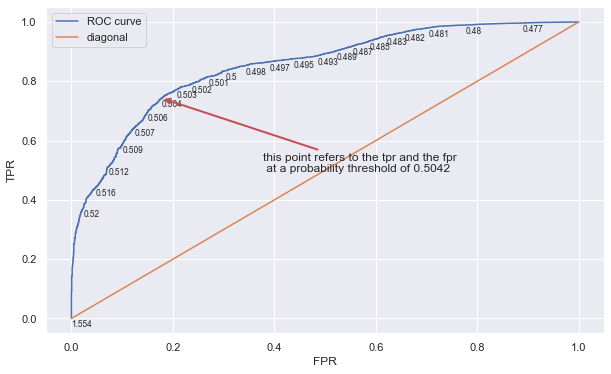

In [96]:
#Train
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::100], tpr[::100], thresholds[::100]):
    plt.annotate(np.round(txt,3), (x, y-0.03), fontsize='x-small')
rnd_idx = 700
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'\
             .format(np.round(thresholds[rnd_idx], 4)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->',color='r'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [97]:
probs = rf_model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:,1])

(<Figure size 720x432 with 1 Axes>, <AxesSubplot:>)

Text(0.0, -0.01, '1.5498')

Text(0.04013377926421405, 0.23209486166007903, '0.5224')

Text(0.08138238573021182, 0.40205533596837945, '0.516')

Text(0.12486064659977704, 0.4791304347826087, '0.5114')

Text(0.1705685618729097, 0.5374308300395256, '0.5091')

Text(0.21516164994425863, 0.6147529644268774, '0.5063')

Text(0.2630992196209587, 0.6626778656126482, '0.505')

Text(0.30657748049052397, 0.7071442687747036, '0.5037')

Text(0.3556298773690078, 0.7451877470355731, '0.5023')

Text(0.4124860646599777, 0.7879249011857707, '0.4998')

Text(0.47045707915273133, 0.8126284584980237, '0.498')

Text(0.5239687848383501, 0.8402964426877471, '0.4951')

Text(0.5808249721293199, 0.8657411067193675, '0.4907')

Text(0.6432552954292085, 0.8924209486166008, '0.4865')

Text(0.7112597547380156, 0.9163833992094862, '0.4843')

Text(0.7937569676700111, 0.9354051383399209, '0.4827')

Text(0.8729096989966555, 0.9534387351778656, '0.4814')

Text(0.935340022296544, 0.972707509881423, '0.4795')

Text(0.5, 0, 'FPR')

Text(0, 0.5, 'TPR')

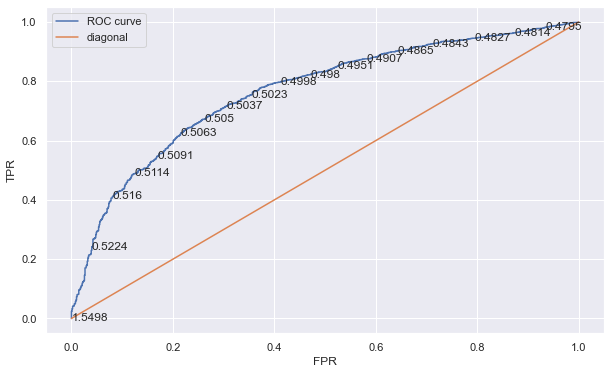

In [98]:
#Test
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::70], tpr[::70], thresholds[::70]):
    plt.annotate(np.round(txt,4), (x, y-0.01))

plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [99]:
X_train = pd.DataFrame(X_train.toarray(), columns=X.columns)
X_train.head()
X_test = pd.DataFrame(X_test.toarray(), columns=X.columns)
X_test.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
0,406.0,2.0,0.158373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,473.0,0.0,0.065000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,332.0,0.0,0.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,246.0,0.0,0.370000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,243.0,1.0,0.138036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
0,297.0,0.0,0.305556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,125.0,0.0,0.157143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,384.0,0.0,0.189610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,255.0,0.0,0.387500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,329.0,4.0,0.341220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
rf_model.classes_
arr= rf_model.predict_proba(X_test)
print(arr)

array([0, 1], dtype=int64)

[[0.49526278 0.50473722]
 [0.51116436 0.48883564]
 [0.50508206 0.49491794]
 ...
 [0.48447957 0.51552043]
 [0.49972776 0.50027224]
 [0.51333702 0.48666298]]


In [101]:
arr_list = arr.tolist()
arr_list[1][1]

0.4888356422393672

In [102]:
proba_list = []
for i in arr_list:
    proba_list.append(i[0])
proba_list[:5]

[0.4952627846625535,
 0.5111643577606327,
 0.5050820620908348,
 0.4951560792586714,
 0.4798222801560534]

In [103]:
X_test['Proba0'] = proba_list
X_test.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7268,7269,7270,7271,7272,7273,7274,7275,7276,Proba0
0,297.0,0.0,0.305556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495263
1,125.0,0.0,0.157143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511164
2,384.0,0.0,0.189610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505082
3,255.0,0.0,0.387500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495156
4,329.0,4.0,0.341220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.479822


In [104]:
prediction_list = []
for i in X_test['Proba0']:
    if i > 0.4998:
        prediction_list.append(0)
    else:
        prediction_list.append(1)
prediction_list[:5]

[1, 0, 0, 1, 1]

In [105]:
X_test['Predictions'] = prediction_list
X_test.head()
print(report(y_test, X_test['Predictions'], rf_model.classes_))

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7269,7270,7271,7272,7273,7274,7275,7276,Proba0,Predictions
0,297.0,0.0,0.305556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495263,1
1,125.0,0.0,0.157143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.511164,0
2,384.0,0.0,0.189610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.505082,0
3,255.0,0.0,0.387500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.495156,1
4,329.0,4.0,0.341220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.479822,1


Confusion Matrix:
     0     1
0  541   356
1  840  3208

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.60      0.47       897
           1       0.90      0.79      0.84      4048

    accuracy                           0.76      4945
   macro avg       0.65      0.70      0.66      4945
weighted avg       0.81      0.76      0.78      4945

